<a href="https://colab.research.google.com/github/Allan19k/Machine-Learning/blob/main/Transfer_Learning_CNN_2_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# instalacion de kaggle para importar la base de datos
!pip install kaggle
!mkdir -p ~/.kaggle
!cp /root/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
1# Importar el dataset de kaggle
!kaggle datasets download oortdatahub/diverse-tools-image-dataset-for-machine-learning -p /content/dataset --unzip

Dataset URL: https://www.kaggle.com/datasets/oortdatahub/diverse-tools-image-dataset-for-machine-learning
License(s): apache-2.0
User cancelled operation


In [ ]:
#resolver problemas de importacion
# 🔧 Paso 1: Desinstalamos las versiones actuales que causan conflicto
!pip uninstall -y tensorflow tensorflow-text tf-keras

# ✅ Paso 2: Instalamos las versiones compatibles entre sí
!pip install tensorflow==2.18.0 tensorflow-text==2.18.1 tf-keras==2.18.0


Found existing installation: tensorflow 2.18.0
Uninstalling tensorflow-2.18.0:
  Successfully uninstalled tensorflow-2.18.0
Found existing installation: tensorflow-text 2.18.1
Uninstalling tensorflow-text-2.18.1:
  Successfully uninstalled tensorflow-text-2.18.1
Found existing installation: tf_keras 2.18.0
Uninstalling tf_keras-2.18.0:
  Successfully uninstalled tf_keras-2.18.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.4/615.4 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 76.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 63.8 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
2# # Modelo preentrenado (Resnet50)
# Define paths
dataset_path = '/content/dataset'

# Image preprocessing and augmentation
image_size = (224, 224)  # Tamaño de entrada para ResNet50
batch_size = 32

datagen = ImageDataGenerator(
    rescale=1./255,  # Normalizar píxeles
    validation_split=0.2,  # 80% entrenamiento, 20% validación
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

train_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)
# Cargar el modelo preentrenado sin la capa superior
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

Found 3998 images belonging to 6 classes.
Found 996 images belonging to 6 classes.
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
3# Acoplar la MLP congelar el 80% de sus capas de convolución y revisar el resultado del modelo (datos de test)
# utilizando una matriz de confusión
# Acoplar una MLP
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

# Congelar un porcentaje de capas (80%)
total_layers = len(base_model.layers)
freeze_layers = int(total_layers * 0.8)
for layer in base_model.layers[:freeze_layers]:
    layer.trainable = False
for layer in base_model.layers[freeze_layers:]:
    layer.trainable = True

# Paso 4: Compilar y entrenar el modelo
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
epochs = 10
model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=epochs
)

# Guardar el modelo
# aparace un warning que indica que el modelo se guardo en un formato antiguo (HDG5), para futuros trabajos
# se utilizara model.save('mi_modelo.keras')
model.save('resnet50_model.h5')

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 221s 2s/step - accuracy: 0.1830 - loss: 2.1860 - val_accuracy: 0.1694 - val_loss: 8.5508
Epoch 2/10
  1/124 ━━━━━━━━━━━━━━━━━━━━ 17s 138ms/step - accuracy: 0.4062 - loss: 1.5950

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


124/124 ━━━━━━━━━━━━━━━━━━━━ 35s 282ms/step - accuracy: 0.4062 - loss: 1.5950 - val_accuracy: 0.1694 - val_loss: 8.3838
Epoch 3/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 202s 2s/step - accuracy: 0.2917 - loss: 1.6852 - val_accuracy: 0.1673 - val_loss: 14.1690
Epoch 4/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 34s 273ms/step - accuracy: 0.3438 - loss: 1.7321 - val_accuracy: 0.1673 - val_loss: 14.1034
Epoch 5/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 153s 1s/step - accuracy: 0.3256 - loss: 1.6427 - val_accuracy: 0.2339 - val_loss: 3.8642
Epoch 6/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 33s 268ms/step - accuracy: 0.3750 - loss: 1.5571 - val_accuracy: 0.2450 - val_loss: 3.5876
Epoch 7/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 170s 1s/step - accuracy: 0.3483 - loss: 1.5969 - val_accuracy: 0.3196 - val_loss: 2.0094
Epoch 8/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 34s 273ms/step - accuracy: 0.3125 - loss: 1.5331 - val_accuracy: 0.3649 - val_loss: 1.9828
Epoch 9/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 168s 1s/step - accuracy: 0.3524 - loss: 1.5899 - val_accur

32/32 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step


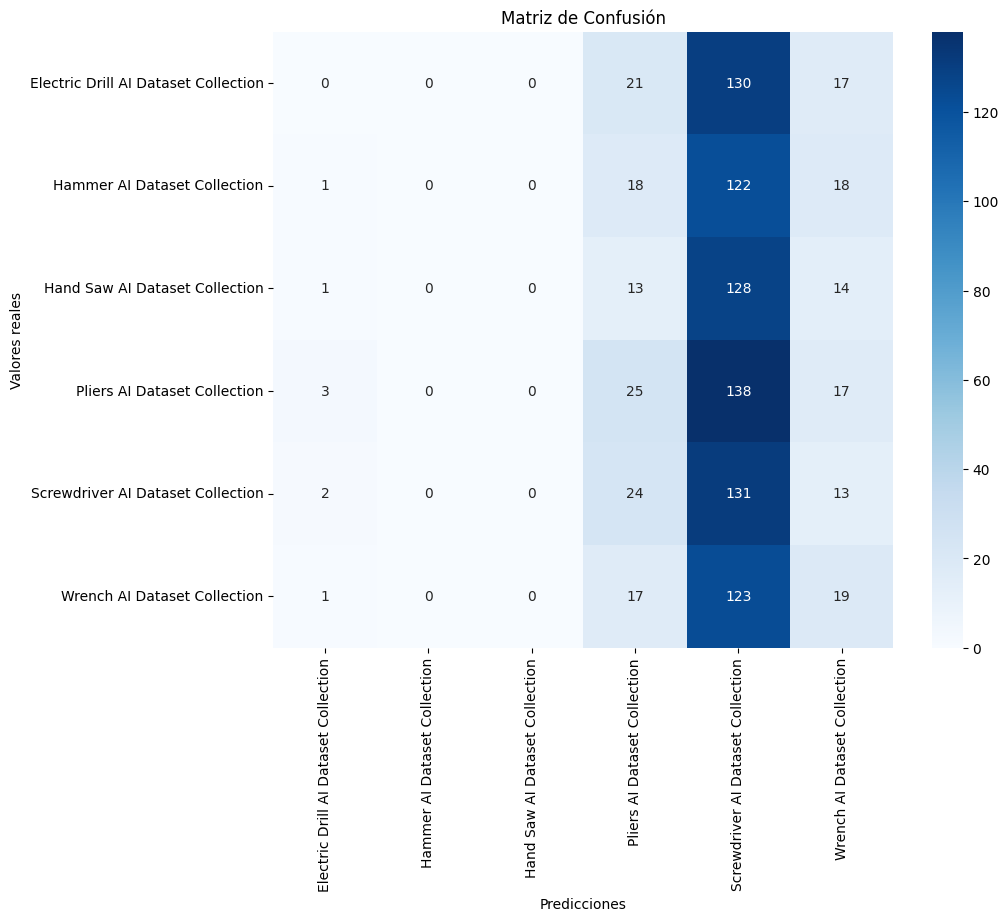

In [ ]:
# prompt: revisar el resultado del modelo (datos de test) a travez de una matriz de confusión
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Asegurar que se recorra todo el set desde el inicio
validation_generator.reset()

# Predicciones
predictions = model.predict(validation_generator)
y_pred = np.argmax(predictions, axis=1)
y_true = validation_generator.classes

# Calcular matriz de confusión
cm = confusion_matrix(y_true, y_pred)
labels = list(validation_generator.class_indices.keys())

# Mostrar matriz
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels,
            yticklabels=labels)
plt.xlabel("Predicciones")
plt.ylabel("Valores reales")
plt.title("Matriz de Confusión")
plt.show()



Epoch 1/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 205s 1s/step - accuracy: 0.2373 - loss: 1.7742 - val_accuracy: 0.1573 - val_loss: 36.7640
Epoch 2/10
  1/124 ━━━━━━━━━━━━━━━━━━━━ 24s 202ms/step - accuracy: 0.2500 - loss: 1.7190

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


124/124 ━━━━━━━━━━━━━━━━━━━━ 34s 278ms/step - accuracy: 0.2500 - loss: 1.7190 - val_accuracy: 0.1562 - val_loss: 39.6750
Epoch 3/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 202s 2s/step - accuracy: 0.2621 - loss: 1.7146 - val_accuracy: 0.2238 - val_loss: 9.3734
Epoch 4/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 34s 274ms/step - accuracy: 0.3438 - loss: 1.7117 - val_accuracy: 0.2248 - val_loss: 9.7901
Epoch 5/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 156s 1s/step - accuracy: 0.3119 - loss: 1.6227 - val_accuracy: 0.2772 - val_loss: 9.8716
Epoch 6/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 33s 268ms/step - accuracy: 0.5000 - loss: 1.5468 - val_accuracy: 0.2319 - val_loss: 11.0947
Epoch 7/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 156s 1s/step - accuracy: 0.3786 - loss: 1.5516 - val_accuracy: 0.1764 - val_loss: 10.4829
Epoch 8/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 34s 275ms/step - accuracy: 0.4062 - loss: 1.5279 - val_accuracy: 0.1774 - val_loss: 11.0380
Epoch 9/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 202s 2s/step - accuracy: 0.4055 - loss: 1.4897 - val_acc

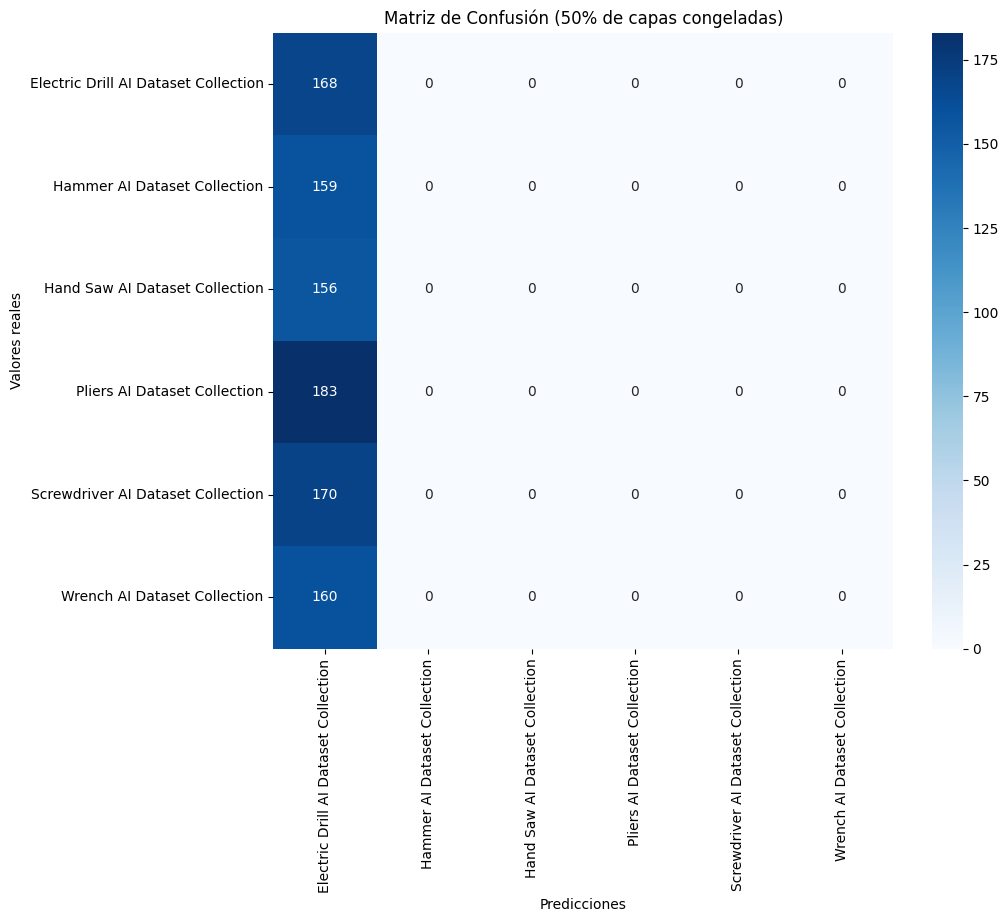

In [ ]:
# prompt:  Dejar congelado solo el 50% de capas del modelo y volver a entrenarlo y revisar de nuevo su desempeño
# con los datos de test visualizando la matriz de confusión
#4  Dejar congelado solo el 50% de capas del modelo y volver a entrenarlo
# y revisar de nuevo su desempeño con los datos de test visualizando la matriz de confusión
# Congelar el 50% de las capas
total_layers = len(base_model.layers)
freeze_layers = int(total_layers * 0.5)  # Congelar el 50% de las capas

for layer in base_model.layers[:freeze_layers]:
    layer.trainable = False
for layer in base_model.layers[freeze_layers:]:
    layer.trainable = True

# Recompilar el modelo (necesario después de cambiar la congelación de capas)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Reentrenar el modelo con las capas parcialmente descongeladas
epochs = 10  # Ajusta el número de épocas según sea necesario
model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=epochs
)

# Evaluar el modelo y visualizar la matriz de confusión (igual que antes)
validation_generator.reset()
predictions = model.predict(validation_generator)
y_pred = np.argmax(predictions, axis=1)
y_true = validation_generator.classes

cm = confusion_matrix(y_true, y_pred)
labels = list(validation_generator.class_indices.keys())

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels,
            yticklabels=labels)
plt.xlabel("Predicciones")
plt.ylabel("Valores reales")
plt.title("Matriz de Confusión (50% de capas congeladas)")
plt.show()


In [ ]:
# RESULTADOS DE AMBOS ENTRENAMIENTOS (PARA CONCLUSION)
# prompt: para ambos entrenamientos que acabo de hacer el primero con 80% de capas congelados y el segundo con 50% de capas congeladas dame lo siguiente: Accuracy final de validación
# Loss final de validación
# Matriz de confusión de ambas para comparar
# Classification report

from sklearn.metrics import classification_report

# ... (Your existing code) ...

# After the first model training (80% frozen layers):
loss_80, accuracy_80 = model.evaluate(validation_generator)
print(f"Modelo 80% congelado - Accuracy de validación: {accuracy_80}")
print(f"Modelo 80% congelado - Loss de validación: {loss_80}")

# Classification report for the first model
print(classification_report(y_true, y_pred, target_names=labels))

# ... (Your existing code for the confusion matrix) ...


# After the second model training (50% frozen layers):
loss_50, accuracy_50 = model.evaluate(validation_generator)
print(f"Modelo 50% congelado - Accuracy de validación: {accuracy_50}")
print(f"Modelo 50% congelado - Loss de validación: {loss_50}")

# Classification report for the second model
print(classification_report(y_true, y_pred, target_names=labels))

# ... (Your existing code for the confusion matrix) ...


32/32 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.1591 - loss: 17.6678
Modelo 80% congelado - Accuracy de validación: 0.16867469251155853
Modelo 80% congelado - Loss de validación: 17.56814956665039
                                      precision    recall  f1-score   support

Electric Drill AI Dataset Collection       0.17      1.00      0.29       168
        Hammer AI Dataset Collection       0.00      0.00      0.00       159
      Hand Saw AI Dataset Collection       0.00      0.00      0.00       156
        Pliers AI Dataset Collection       0.00      0.00      0.00       183
   Screwdriver AI Dataset Collection       0.00      0.00      0.00       170
        Wrench AI Dataset Collection       0.00      0.00      0.00       160

                            accuracy                           0.17       996
                           macro avg       0.03      0.17      0.05       996
                        weighted avg       0.03      0.17      0.05       996



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


32/32 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.1754 - loss: 17.2840
Modelo 50% congelado - Accuracy de validación: 0.16867469251155853
Modelo 50% congelado - Loss de validación: 17.57381820678711
                                      precision    recall  f1-score   support

Electric Drill AI Dataset Collection       0.17      1.00      0.29       168
        Hammer AI Dataset Collection       0.00      0.00      0.00       159
      Hand Saw AI Dataset Collection       0.00      0.00      0.00       156
        Pliers AI Dataset Collection       0.00      0.00      0.00       183
   Screwdriver AI Dataset Collection       0.00      0.00      0.00       170
        Wrench AI Dataset Collection       0.00      0.00      0.00       160

                            accuracy                           0.17       996
                           macro avg       0.03      0.17      0.05       996
                        weighted avg       0.03      0.17      0.05       996



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# **Resumen**
En este experimento se utilizó el modelo preentrenado ResNet50 (extraído desde Keras con pesos entrenados en ImageNet) para realizar una clasificación de herramientas a partir de un conjunto de imágenes descargado desde Kaggle. El dataset incluía 6 clases: taladro, martillo, serrucho, pinzas, destornillador y llave inglesa, con un total de 3998 imágenes para entrenamiento y 996 para validación.

Primero, se congeló el 80% de las capas convolucionales del modelo, se acopló una capa MLP con GlobalAveragePooling y dos capas densas (la última con activación softmax), y se entrenó por 10 épocas. Posteriormente, se repitió el entrenamiento congelando ahora solo el 50% de las capas, para observar cómo variaba el desempeño del modelo.

En ambas versiones, se evaluó el desempeño utilizando la matriz de confusión y métricas como accuracy, precision, recall y f1-score.
# **Explicación de la función de pérdida y el optimizador**
Se utilizó como función de pérdida categorical_crossentropy, que es adecuada para problemas de clasificación multiclase con etiquetas codificadas en formato one-hot. Esta función calcula la discrepancia entre la distribución de probabilidad verdadera (etiqueta real) y la distribución predicha por el modelo (salida del softmax). Penaliza fuertemente predicciones erróneas y favorece aquellas que asignan una alta probabilidad a la clase correcta.
Matemáticamente, para una instancia con una clase verdadera y y una predicción y^​, la pérdida es:

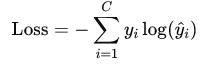

donde C es el número de clases, yi​ es la etiqueta real (1 si es la clase correcta, 0 en caso contrario), y y^i ​ es la probabilidad predicha por el modelo para la clase i.

Como optimizador se empleó Adam, que es una combinación adaptativa de RMSProp y Momentum, el cual ajusta la tasa de aprendizaje para cada parámetro individualmente. Adam es ideal en contextos donde se necesita convergencia rápida y eficiente, y se adapta bien a problemas con ruido y gradientes dispersos.

Su fórmula de actualización incluye términos que acumulan tanto el promedio de los gradientes (momentum) como el promedio de los cuadrados de los gradientes (aceleración adaptativa), mejorando la estabilidad en el aprendizaje.

# **Conclusión**
El modelo, aunque correctamente armado y entrenado según lo requerido, no mostró un desempeño satisfactorio en la tarea de clasificación. Tanto con el 80% como con el 50% de capas congeladas, el accuracy de validación fue de aproximadamente 0.17, y la mayoría de las clases no fueron correctamente clasificadas. Solo una clase (taladro eléctrico) mostró un buen recall (1.00), mientras que las demás obtuvieron valores de precisión y recall de 0.00.

Esto generó una serie de warnings como UndefinedMetricWarning, indicando que el modelo no estaba prediciendo ninguna instancia correctamente para varias clases, por lo que Precision, Recall y F1-score fueron indefinidos.

Las posibles causas de este mal desempeño podrían ser:

    Pocas épocas de entrenamiento

    Dataset desbalanceado entre clases

    Congelación excesiva de capas (incluso con el 50%)

    Capacidad insuficiente del clasificador MLP acoplado

    Falta de regularización (como dropout o batch normalization)

🔧 Posibles soluciones:

    Entrenar durante más épocas (por ejemplo, 30 o más)

    Aumentar el tamaño del clasificador denso

    Aplicar técnicas de data augmentation más agresivas

    Usar class weights para balancear el entrenamiento

    Congelar menos capas o usar fine-tuning progresivo

🧪 Conclusión final:

El experimento sí es válido desde el punto de vista técnico y cumple con los objetivos de la tarea (uso de un modelo preentrenado, acoplamiento de MLP, control de capas, uso de matriz de confusión). Sin embargo, el desempeño obtenido no es óptimo para un sistema real, lo cual abre la puerta a mejoras futuras aplicando las soluciones propuestas.